# Installation of packages and imports

In [1]:
%tensorflow_version 1.x
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y python=3.7
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

TensorFlow 1.x selected.
--2021-02-24 05:09:53--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94235922 (90M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  89.87M   333MB/s    in 0.3s    

2021-02-24 05:09:53 (333 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [94235922/94235922]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - brotlipy==0.7.0=py38h27cfd23_1003
    - ca-certificates==2020.10.14=0
    - certifi==2020.6.20=pyhd3eb1b0_3
    - cffi==1.14.3=py38h261ae71_2
    - chardet==3.0.4=py38h06a4308_1003
    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
np.random.seed(55)
import tensorflow as tf
tf.set_random_seed(55)
import deepchem as dc

import os
import pandas as pd
import copy

# Functions

In [3]:
def train_model(dataset, model, splitter, augment):
  final_train_scores = {'mean-accuracy_score': [],
                  'mean-recall_score': [],
                  'mean-roc_auc_score': [],
                  'mean-precision_score': []}

  final_test_scores = {'mean-accuracy_score': [],
                  'mean-recall_score': [],
                  'mean-roc_auc_score': [],
                  'mean-precision_score': []}

  roc_curve_data = {
      'fpr': [],
      'tpr': []
  }

  if augment:
    for train_idx, test_idx in splitter.split(dataset.X[:322], dataset.y[:322]):
      train_idx_aug = train_idx

      for i in range(10):
        train_idx_aug = np.append(train_idx_aug, train_idx * 10 + 322 + i)

      train_dataset = dataset.select(train_idx_aug)
      test_dataset = dataset.select(test_idx)

      model_copy = copy.copy(model)
      
      model_copy.fit(train_dataset, nb_epoch=num_epochs, deterministic=True)

      train_scores = model_copy.evaluate(train_dataset, [aucroc, acc, recall])
      test_scores = model_copy.evaluate(test_dataset, [aucroc, acc, recall])

      final_train_scores['mean-accuracy_score'].append(train_scores['mean-accuracy_score'])
      final_train_scores['mean-recall_score'].append(train_scores['mean-recall_score'])
      final_train_scores['mean-roc_auc_score'].append(train_scores['mean-roc_auc_score'])

      final_test_scores['mean-accuracy_score'].append(test_scores['mean-accuracy_score'])
      final_test_scores['mean-recall_score'].append(test_scores['mean-recall_score'])
      final_test_scores['mean-roc_auc_score'].append(test_scores['mean-roc_auc_score'])

      # precision has to be calculated with sklearn
      tmp_train = model_copy.predict(train_dataset)
      tmp_test = model_copy.predict(test_dataset)
      
      tmp_train_ = [0 if i > 0.5 else 1 for i in tmp_train[:,0,0]]
      tmp_test_ = [0 if i > 0.5 else 1 for i in tmp_test[:,0,0]]
      
      final_train_scores['mean-precision_score'].append(precision_score(train_dataset.y, tmp_train_))
      final_test_scores['mean-precision_score'].append(precision_score(test_dataset.y, tmp_test_))

      # roc curve
      fpr, tpr, _ = roc_curve(test_dataset.y, tmp_test[:,0,1])
      roc_curve_data['fpr'].append(fpr)
      roc_curve_data['tpr'].append(tpr)

  else:
    for train_idx, test_idx in splitter.split(dataset.X, dataset.y):

      train_dataset = dataset.select(train_idx)
      test_dataset = dataset.select(test_idx)

      model_copy = copy.copy(model)
      
      model_copy.fit(train_dataset, nb_epoch=num_epochs, deterministic=True)

      train_scores = model_copy.evaluate(train_dataset, [aucroc, acc, recall])
      test_scores = model_copy.evaluate(test_dataset, [aucroc, acc, recall])

      final_train_scores['mean-accuracy_score'].append(train_scores['mean-accuracy_score'])
      final_train_scores['mean-recall_score'].append(train_scores['mean-recall_score'])
      final_train_scores['mean-roc_auc_score'].append(train_scores['mean-roc_auc_score'])

      final_test_scores['mean-accuracy_score'].append(test_scores['mean-accuracy_score'])
      final_test_scores['mean-recall_score'].append(test_scores['mean-recall_score'])
      final_test_scores['mean-roc_auc_score'].append(test_scores['mean-roc_auc_score'])

      # precision has to be calculated with sklearn
      tmp_train = model_copy.predict(train_dataset)
      tmp_test = model_copy.predict(test_dataset)
      
      tmp_train_ = [0 if i > 0.5 else 1 for i in tmp_train[:,0,0]]
      tmp_test_ = [0 if i > 0.5 else 1 for i in tmp_test[:,0,0]]
      
      final_train_scores['mean-precision_score'].append(precision_score(train_dataset.y, tmp_train_))
      final_test_scores['mean-precision_score'].append(precision_score(test_dataset.y, tmp_test_))

      # roc curve
      fpr, tpr, _ = roc_curve(test_dataset.y, tmp_test[:,0,1])
      roc_curve_data['fpr'].append(fpr)
      roc_curve_data['tpr'].append(tpr)

  return final_train_scores, final_test_scores, roc_curve_data

In [4]:
def print_scores(train_scores, test_scores):
  print("AUCROC train:", '\t', np.mean(train_scores['mean-roc_auc_score']), "+-", np.std(train_scores['mean-roc_auc_score']))
  print("AUCROC test:", '\t', np.mean(test_scores['mean-roc_auc_score']), "+-", np.std(test_scores['mean-roc_auc_score']), "\n")

  print("ACCURACY  train:", '\t', np.mean(train_scores['mean-accuracy_score']), "+-", np.std(train_scores['mean-accuracy_score']))
  print("ACCURACY  test:", '\t', np.mean(test_scores['mean-accuracy_score']), "+-", np.std(test_scores['mean-accuracy_score']), "\n")

  print("RECALL train:", '\t', np.mean(train_scores['mean-recall_score']), "+-", np.std(train_scores['mean-recall_score']))
  print("RECALL test:", '\t', np.mean(test_scores['mean-recall_score']), "+-", np.std(test_scores['mean-recall_score']), "\n")

  print("PRECISION train:", '\t', np.mean(train_scores['mean-precision_score']), "+-", np.std(train_scores['mean-precision_score']))
  print("PRECISION test:", '\t', np.mean(test_scores['mean-precision_score']), "+-", np.std(test_scores['mean-precision_score']))

# Data

In [45]:
# define the path to the dataset for training
input_data = os.path.join("/content/drive/My Drive/Colab Notebooks/TFM MUBICS/datasets/",'mergedData2.csv')
input_data_augmented = os.path.join("/content/drive/My Drive/Colab Notebooks/TFM MUBICS/datasets/",'augmented.csv')

# define the path to new prediction data
pred_data = os.path.join("/content/drive/My Drive/Colab Notebooks/TFM MUBICS/datasets/",'COCONUT_DB_class.csv')

In [46]:
# load data as df for exploratory analysis
input_data_df = pd.read_csv(input_data)
input_data_augmented_df = pd.read_csv(input_data_augmented)
pred_data_df = pd.read_csv(pred_data)


In [47]:
print("# samples of input data:", len(input_data_df))
print("# samples of input data augmented:", len(input_data_augmented_df), '\n')

print("# samples in each class:")
print(input_data_df['Class'].value_counts())
print(input_data_augmented_df['Class'].value_counts(), '\n')

print("# samples of prediction data:", len(pred_data_df))


# samples of input data: 333
# samples of input data augmented: 3542 

# samples in each class:
0    212
1    121
Name: Class, dtype: int64
0    2299
1    1243
Name: Class, dtype: int64 

# samples of prediction data: 401624


# Metrics and k-fold

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve


# metrics for the classifier
aucroc = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification")
acc = dc.metrics.Metric(dc.metrics.accuracy_score, np.mean, mode="classification")
recall = dc.metrics.Metric(dc.metrics.recall_score, np.mean, mode="classification")


# splitter
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=55)
skf_augmented = StratifiedKFold(n_splits=3, shuffle=False, random_state=55)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [9]:
# roc curve data points
roc_curve_data = {}
roc_curve_data_augmented = {}

# GraphConvModel

In [ ]:
# define output name (Class)
tasks=['Class']

# define features
featurizer=dc.feat.ConvMolFeaturizer()

# load data and calculate the features for dataset
loader = dc.data.CSVLoader(tasks=tasks, smiles_field="smiles", featurizer=featurizer)
dataset = loader.featurize(input_data, data_dir='/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/ConvMolFeaturizer/non-augmented/')
dataset_augmented = loader.featurize(input_data_augmented, data_dir='/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/ConvMolFeaturizer/augmented/')
# dataset = dc.data.DiskDataset('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/ConvMolFeaturizer/non-augmented/')  # load features if already calculated
# dataset_augmented = dc.data.DiskDataset('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/ConvMolFeaturizer/augmented/')

# calculate the same features for new data to predict
loader2 = dc.data.CSVLoader(tasks=tasks, smiles_field="unique_smiles", featurizer=featurizer)
dataset_pred = loader2.featurize(pred_data, data_dir='/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_predictions/ConvMolFeaturizer/')
# dataset_pred = dc.data.DiskDataset('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_predictions/ConvMolFeaturizer/')

In [49]:
# model creation
from deepchem.models import GraphConvModel

# batch size
batch_size = 32

# dropout 
n_dropout = 0.3

# num epochs
num_epochs = 150

model = GraphConvModel(len(tasks),
                         n_classes=2,
                         batch_size=batch_size,
                         mode='classification',
                         dropout=n_dropout,
                         random_seed=55)

Exception ignored in: <function Model.__del__ at 0x7f296edae7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/deepchem/models/models.py", line 62, in __del__
    shutil.rmtree(self.model_dir)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpdwyhgx_a'


In [15]:
# training
train_scores, test_scores, roc_curve_data['GraphConvModel'] = train_model(dataset, model, skf, False)
train_scores_augmented, test_scores_augmented, roc_curve_data_augmented['GraphConvModel'] = train_model(dataset_augmented, model, skf_augmented, True)

TIMING: dataset construction took 0.125 s
Loading dataset from disk.
TIMING: dataset construction took 0.094 s
Loading dataset from disk.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9892303651168899]
computed_metrics: [0.9459459459459459]
computed_metrics: [0.8765432098765432]
computed_metrics: [0.7355633802816901]
computed_metrics: [0.7657657657657657]
computed_metrics: [0.6]
TIMING: dataset construction took 0.127 s
Loading dataset from disk.
TIMING: dataset construction took 0.093 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9955345416338324]
computed_metrics: [0.9684684684684685]
computed_metrics: [0.9629629629629629]
computed_metrics: [0.7668133802816901]
computed_metrics: [0.7117117117117117]
computed_metrics: [0.525]
TIMING: dataset construction took 0.124 s
Loading dataset from disk.
TIMING: dataset construction took 0.091 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.990669014084507]
computed_metrics: [0.9369369369369369]
computed_metrics: [0.8375]
computed_metrics: [0.8097560975609757]
computed_metrics: [0.7747747747747747]
computed_metrics: [0.5609756097560976]
TIMING: dataset construction took 1.427 s
Loading dataset from disk.
TIMING: dataset construction took 0.778 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [1.0]
computed_metrics: [0.9949022939677146]
computed_metrics: [1.0]
computed_metrics: [0.6929511278195488]
computed_metrics: [0.6666666666666666]
computed_metrics: [0.5]
TIMING: dataset construction took 1.740 s
Loading dataset from disk.
TIMING: dataset construction took 0.575 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [0.9999828350825943]
computed_metrics: [0.999154334038055]
computed_metrics: [0.9976218787158145]
computed_metrics: [0.7595559845559846]
computed_metrics: [0.6635514018691588]
computed_metrics: [0.32432432432432434]
TIMING: dataset construction took 1.494 s
Loading dataset from disk.
TIMING: dataset construction took 0.822 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [1.0]
computed_metrics: [1.0]
computed_metrics: [1.0]
computed_metrics: [0.6954614797864227]
computed_metrics: [0.6635514018691588]
computed_metrics: [0.6578947368421053]


In [18]:
# metrics
print("NORMAL DATASET METRICS:")
print_scores(train_scores, test_scores)
print('\n\n', "AUGMENTED DATASET METRICS:", sep='')
print_scores(train_scores_augmented, test_scores_augmented)

NORMAL DATASET METRICS:
AUCROC train: 	 0.9918113069450764 +- 0.0026974413955540826
AUCROC test: 	 0.7707109527081185 +- 0.03041417572377987 

ACCURACY  train: 	 0.9504504504504504 +- 0.013260902201693467
ACCURACY  test: 	 0.7507507507507508 +- 0.0278487041906778 

RECALL train: 	 0.892335390946502 +- 0.05242317239587359
RECALL test: 	 0.5619918699186992 +- 0.03062705327580576 

PRECISION train: 	 0.969705456522736 +- 0.014060947612598252
PRECISION test: 	 0.6967320261437909 +- 0.06118010156254412


AUGMENTED DATASET METRICS:
AUCROC train: 	 0.9999942783608647 +- 8.091619664035334e-06
AUCROC test: 	 0.7159895307206522 +- 0.030823177335559462 

ACCURACY  train: 	 0.9980188760019232 +- 0.002230635247601309
ACCURACY  test: 	 0.6645898234683281 +- 0.0014685499090063294 

RECALL train: 	 0.9992072929052714 +- 0.0011210571243544015
RECALL test: 	 0.4940730203888099 +- 0.13624402578291703 

PRECISION train: 	 0.9951690821256038 +- 0.006831949576681597
PRECISION test: 	 0.523450080515298 +- 0.

### Predictions

In [ ]:
# train final model
model = GraphConvModel(len(tasks),
                         n_classes=2,
                         batch_size=batch_size,
                         mode='classification',
                         dropout=n_dropout,
                         model_dir='/content/drive/My Drive/Colab Notebooks/TFM MUBICS/models/GraphConvModel/',
                         random_seed=55)

model.fit(dataset, nb_epoch=num_epochs, deterministic=True)









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0.015488644402166756

In [50]:
# read final model
# model.restore(model_dir="/content/drive/My Drive/Colab Notebooks/TFM MUBICS/models/GraphConvModel/")

In [ ]:
# make predictions
predictions = model.predict(dataset_pred)

In [52]:
# dataframe to save predictions (only positive class)
tmp = pd.DataFrame()
tmp['unique_smiles'] = dataset_pred.ids
tmp['ProbClass1'] = predictions[:,0,1]
tmp.head()

,unique_smiles,ProbClass1
0,O=C1OC2=CC(=CC(OC3OC(CO)C(O)C(O)C3O)=C2C4=C1CC...,0.411889
1,O=C1C=C(OC=2C1=C(O)C=C(O)C2C(C=3C=CC=CC3)CC(=O...,0.496683
2,O=C(NC1OCOC2C1OC(CC(OC)CO)C(C)(C)C2OC)C(O)C3(O...,0.148713
3,O=C(OC1C(=C)C2CCC3(O)C4(C)CCCC(C(=O)O)(C)C4CCC...,0.178756
4,O=P(O)(O)OCC1OC(OP(=O)(O)O)C(O)C1O,0.050634


In [53]:
GraphConvModel_predictions = pd.merge(left=pred_data_df, right=tmp, left_on='unique_smiles', right_on='unique_smiles')

In [54]:
GraphConvModel_predictions = GraphConvModel_predictions.sort_values(by='ProbClass1', ascending=False)

In [55]:
GraphConvModel_predictions = GraphConvModel_predictions.drop(['Unnamed: 0', 'Class'], axis=1)

In [56]:
# final results
GraphConvModel_predictions.head()

,unique_smiles,coconut_id,ProbClass1
29008,ClC=1C=C2C(=CC1Cl)N(C(=CC=CC3N(C4=CC(Cl)=C(Cl)...,CNP0423946,0.999865
51202,O=C(OC(OC(=O)C)C1=CC=CC(=C1)C2=NN=C(O2)C=3C=CC...,CNP0037288,0.999846
258797,O=C1OC2=C(OC(=O)CC(C)C)C=3OC=CC3C=C2C=C1,CNP0105983,0.999786
250138,O=C(C(=CC(C)C(O)C(=CC(C)C(O)C(=CC(C)C(O)C(=CC(...,CNP0354199,0.999780
330538,O=C(OC=1C=CC=CC1C2=NC=3N=C(OS3O2)C=4C=CC=CC4OC...,CNP0394629,0.999778


In [ ]:
# save results
GraphConvModel_predictions.to_csv("/content/drive/My Drive/Colab Notebooks/TFM MUBICS/predictions/GraphConvModel_predictions.csv", index=False)

# Weave Model

In [ ]:
# define output name (Class)
tasks=['Class']

# define features
featurizer = dc.feat.WeaveFeaturizer()

# load data and calculate the features for dataset
loader = dc.data.CSVLoader(tasks=tasks, smiles_field="smiles", featurizer=featurizer)
dataset = loader.featurize(input_data, data_dir='/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/WeaveFeaturizer/non-augmented/')
dataset_augmented = loader.featurize(input_data_augmented, data_dir='/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/WeaveFeaturizer/augmented/')
# dataset = dc.data.DiskDataset('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/WeaveFeaturizer/non-augmented/')
# dataset_augmented = dc.data.DiskDataset('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/WeaveFeaturizer/augmented/')


In [20]:
# model creation
from deepchem.models import WeaveModel

# batch size
batch_size = 128

# dropout 
n_dropout = 0.2

# num epochs
num_epochs = 200

model = WeaveModel(n_tasks=len(tasks),
                     dropouts=n_dropout,
                     mode="classification",
                     n_classes=2,
                     batch_size=batch_size,
                     random_seed=55)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


Exception ignored in: <bound method Model.__del__ of GraphConvModel(batch_size=32, dense_layer_size=128, dropout=[0.3, 0.3, 0.3],
               graph_conv_layers=[64, 64], mode='classification', n_classes=2,
               n_tasks=1, number_atom_features=75, uncertainty=False)>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/deepchem/models/models.py", line 62, in __del__
    shutil.rmtree(self.model_dir)
  File "/usr/lib/python3.6/shutil.py", line 477, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 475, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp8ziu9hxy'


In [23]:
# training
train_scores, test_scores, roc_curve_data['WeaveModel'] = train_model(dataset, model, skf, False)
train_scores_augmented, test_scores_augmented, roc_curve_data_augmented['WeaveModel'] = train_model(dataset_augmented, model, skf_augmented, True)

TIMING: dataset construction took 0.314 s
Loading dataset from disk.
TIMING: dataset construction took 0.225 s
Loading dataset from disk.
computed_metrics: [0.9843271167148235]
computed_metrics: [0.9054054054054054]
computed_metrics: [0.7654320987654321]
computed_metrics: [0.7873239436619718]
computed_metrics: [0.7657657657657657]
computed_metrics: [0.45]
TIMING: dataset construction took 0.305 s
Loading dataset from disk.
TIMING: dataset construction took 0.219 s
Loading dataset from disk.
computed_metrics: [0.9801243323701954]
computed_metrics: [0.8963963963963963]
computed_metrics: [0.9629629629629629]
computed_metrics: [0.776056338028169]
computed_metrics: [0.7207207207207207]
computed_metrics: [0.7]
TIMING: dataset construction took 0.300 s
Loading dataset from disk.
TIMING: dataset construction took 0.216 s
Loading dataset from disk.
computed_metrics: [0.955105633802817]
computed_metrics: [0.8513513513513513]
computed_metrics: [0.6375]
computed_metrics: [0.6926829268292684]
compu

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TIMING: dataset construction took 3.154 s
Loading dataset from disk.
TIMING: dataset construction took 1.458 s
Loading dataset from disk.
computed_metrics: [0.4996459735785108]
computed_metrics: [0.6443974630021142]
computed_metrics: [0.0]
computed_metrics: [0.5035714285714286]
computed_metrics: [0.6542056074766355]
computed_metrics: [0.0]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TIMING: dataset construction took 3.455 s
Loading dataset from disk.
TIMING: dataset construction took 1.434 s
Loading dataset from disk.
computed_metrics: [0.5]
computed_metrics: [0.6503171247357293]
computed_metrics: [0.0]
computed_metrics: [0.4891304347826087]
computed_metrics: [0.6448598130841121]
computed_metrics: [0.0]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# metrics
print("NORMAL DATASET METRICS:")
print_scores(train_scores, test_scores)
print('\n\n', "AUGMENTED DATASET METRICS:", sep='')
print_scores(train_scores_augmented, test_scores_augmented)

NORMAL DATASET METRICS:
AUCROC train: 	 0.9731856942959453 +- 0.012899154743321933
AUCROC test: 	 0.7520210695064696 +- 0.04220980230913711 

ACCURACY  train: 	 0.8843843843843843 +- 0.02364566929132676
ACCURACY  test: 	 0.7147147147147147 +- 0.04433880798868885 

RECALL train: 	 0.7886316872427983 +- 0.13387855378239166
RECALL test: 	 0.4727642276422764 +- 0.17697732330959015 

PRECISION train: 	 0.8973136982065553 +- 0.0736697625819507
PRECISION test: 	 0.6642912891513116 +- 0.10903289601517749


AUGMENTED DATASET METRICS:
AUCROC train: 	 0.49988199119283694 +- 0.00016688965556947266
AUCROC test: 	 0.4951863354037267 +- 0.006121243274666766 

ACCURACY  train: 	 0.6493568591808104 +- 0.0037198013450212572
ACCURACY  test: 	 0.649071189569632 +- 0.0038708287059458276 

RECALL train: 	 0.0 +- 0.0
RECALL test: 	 0.0 +- 0.0 

PRECISION train: 	 0.0 +- 0.0
PRECISION test: 	 0.0 +- 0.0


# ChemCeption

In [ ]:
# define output name (Class)
tasks=['Class']

# define features
featurizer = dc.feat.SmilesToImage()

# load data and calculate the features for dataset
loader = dc.data.CSVLoader(tasks=tasks, smiles_field="smiles", featurizer=featurizer)
dataset = loader.featurize(input_data, data_dir='/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/SmilesToImage/non-augmented/')
dataset_augmented = loader.featurize(input_data_augmented, data_dir='/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/SmilesToImage/augmented/')
# dataset = dc.data.DiskDataset('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/SmilesToImage/non-augmented/')
# dataset_augmented = dc.data.DiskDataset('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/SmilesToImage/augmented/')


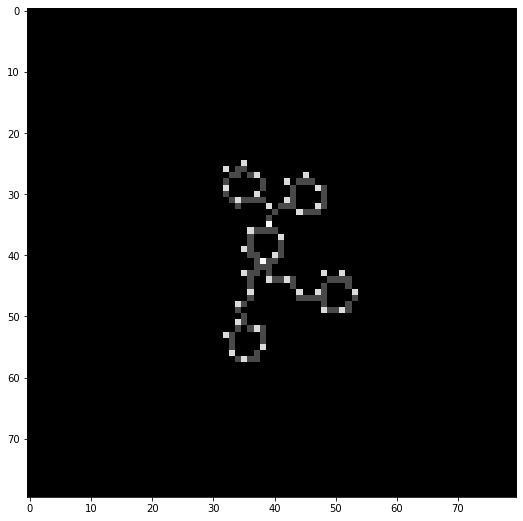

In [27]:
# visualization of one molecule

import matplotlib.pyplot as plt

im = dataset.X[0]
im = im.reshape((80,80))

plt.figure(figsize=(9,9))
plt.imshow(im, cmap='gray')
plt.show()

In [28]:
# model creation
from deepchem.models import ChemCeption

# batch size
batch_size = 128

# num epochs
num_epochs = 150

model = ChemCeption(n_tasks=len(tasks),
                      #dropouts=n_dropout,
                      mode="classification",
                      n_classes=2,
                      batch_size=batch_size,
                      random_seed=55)

Exception ignored in: <bound method Model.__del__ of WeaveModel(batch_size=128, mode='classification', n_atom_feat=75, n_classes=2,
           n_graph_feat=128, n_hidden=50, n_pair_feat=14, n_tasks=1)>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/deepchem/models/models.py", line 62, in __del__
    shutil.rmtree(self.model_dir)
  File "/usr/lib/python3.6/shutil.py", line 477, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 475, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmprssrp8nz'


In [30]:
# training
train_scores, test_scores, roc_curve_data['ChemCeption'] = train_model(dataset, model, skf, False)
train_scores_augmented, test_scores_augmented, roc_curve_data_augmented['ChemCeption'] = train_model(dataset_augmented, model, skf_augmented, True)

TIMING: dataset construction took 0.086 s
Loading dataset from disk.
TIMING: dataset construction took 0.068 s
Loading dataset from disk.

computed_metrics: [1.0]
computed_metrics: [1.0]
computed_metrics: [1.0]
computed_metrics: [0.5608274647887325]
computed_metrics: [0.5315315315315315]
computed_metrics: [0.425]
TIMING: dataset construction took 0.090 s
Loading dataset from disk.
TIMING: dataset construction took 0.065 s
Loading dataset from disk.
computed_metrics: [0.9998248839856405]
computed_metrics: [0.9819819819819819]
computed_metrics: [1.0]
computed_metrics: [0.6889084507042254]
computed_metrics: [0.6936936936936937]
computed_metrics: [0.4]
TIMING: dataset construction took 0.084 s
Loading dataset from disk.
TIMING: dataset construction took 0.068 s
Loading dataset from disk.
computed_metrics: [0.9998679577464789]
computed_metrics: [0.990990990990991]
computed_metrics: [0.975]
computed_metrics: [0.5708188153310105]
computed_metrics: [0.6126126126126126]
computed_metrics: [0.341

In [32]:
# metrics
print("NORMAL DATASET METRICS:")
print_scores(train_scores, test_scores)
print('\n\n', "AUGMENTED DATASET METRICS:", sep='')
print_scores(train_scores_augmented, test_scores_augmented)

NORMAL DATASET METRICS:
AUCROC train: 	 0.9998976139107064 +- 7.4502888887206e-05
AUCROC test: 	 0.6068515769413227 +- 0.05816616811755991 

ACCURACY  train: 	 0.990990990990991 +- 0.007355825053402953
ACCURACY  test: 	 0.6126126126126126 +- 0.06620242548062644 

RECALL train: 	 0.9916666666666667 +- 0.011785113019775802
RECALL test: 	 0.38882113821138214 +- 0.035007765679568904 

PRECISION train: 	 0.9843137254901961 +- 0.022183742154872104
PRECISION test: 	 0.4838721664808621 +- 0.10109011170020762


AUGMENTED DATASET METRICS:
AUCROC train: 	 0.9993353166860818 +- 0.00041011539024934647
AUCROC test: 	 0.49519129296017167 +- 0.02188115146525554 

ACCURACY  train: 	 0.9882785692174956 +- 0.0038217743899634014
ACCURACY  test: 	 0.5403253721010729 +- 0.025299060871750247 

RECALL train: 	 0.9782198500776755 +- 0.003632231086943422
RECALL test: 	 0.3620199146514936 +- 0.08422886591783181 

PRECISION train: 	 0.9881152219818938 +- 0.007620957086486333
PRECISION test: 	 0.3501355013550136 +

# DAGModel

In [16]:
from rdkit import Chem

# max number of atoms per input molecule
print(input_data_df['smiles'].apply(lambda x: len(Chem.MolFromSmiles(x).GetAtoms())).max())
print(input_data_augmented_df['smiles'].apply(lambda x: len(Chem.MolFromSmiles(x).GetAtoms())).max())

59
59


In [27]:
# define output name (Class)
tasks=['Class']

# define features
featurizer = dc.feat.ConvMolFeaturizer()

# load data and calculate the features for dataset
loader = dc.data.CSVLoader(tasks=tasks, smiles_field="smiles", featurizer=featurizer)
# dataset = loader.featurize(input_data, data_dir='/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/ConvMolFeaturizer/non-augmented/')
# dataset_augmented = loader.featurize(input_data_augmented, data_dir='/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/ConvMolFeaturizer/augmented/')
dataset = dc.data.DiskDataset('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/ConvMolFeaturizer/non-augmented/')
dataset_augmented = dc.data.DiskDataset('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/ConvMolFeaturizer/augmented/')


Loading dataset from disk.
Loading dataset from disk.


In [28]:
# define transformer
transformer = dc.trans.DAGTransformer(max_atoms=59)

# apply transformation
dataset = transformer.transform(dataset)

TIMING: dataset construction took 6.618 s
Loading dataset from disk.


In [29]:
# apply transformation to augmented dataset
batches = []
for i in dataset_augmented.iterbatches(batch_size=300, deterministic=True):
  tmp = dc.data.DiskDataset.from_numpy(i[0],i[1])
  tmp = transformer.transform(tmp)
  batches.append(tmp)

dataset_augmented = dc.data.DiskDataset.merge(batches)

TIMING: dataset construction took 0.119 s
Loading dataset from disk.
TIMING: dataset construction took 5.943 s
Loading dataset from disk.
TIMING: dataset construction took 0.155 s
Loading dataset from disk.
TIMING: dataset construction took 8.898 s
Loading dataset from disk.
TIMING: dataset construction took 0.148 s
Loading dataset from disk.
TIMING: dataset construction took 6.728 s
Loading dataset from disk.
TIMING: dataset construction took 0.136 s
Loading dataset from disk.
TIMING: dataset construction took 5.838 s
Loading dataset from disk.
TIMING: dataset construction took 0.144 s
Loading dataset from disk.
TIMING: dataset construction took 7.099 s
Loading dataset from disk.
TIMING: dataset construction took 0.133 s
Loading dataset from disk.
TIMING: dataset construction took 5.621 s
Loading dataset from disk.
TIMING: dataset construction took 0.130 s
Loading dataset from disk.
TIMING: dataset construction took 5.472 s
Loading dataset from disk.
TIMING: dataset construction took 

In [30]:
# model creation
from deepchem.models import DAGModel

# batch size
batch_size = 64

# dropout 
n_dropout = 0.1

# num epochs
num_epochs = 150

model = DAGModel(n_tasks=len(tasks),
                     dropout=n_dropout,
                     mode="classification",
                     n_classes=2,
                     batch_size=batch_size,
                     max_atoms=59,
                     random_seed=55)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [32]:
# training
train_scores, test_scores, roc_curve_data['DAGModel'] = train_model(dataset, model, skf, False)
train_scores_augmented, test_scores_augmented, roc_curve_data_augmented['DAGModel'] = train_model(dataset_augmented, model, skf_augmented, True)

TIMING: dataset construction took 1.847 s
Loading dataset from disk.
TIMING: dataset construction took 1.360 s
Loading dataset from disk.
computed_metrics: [1.0]
computed_metrics: [1.0]
computed_metrics: [1.0]
computed_metrics: [0.7746478873239437]
computed_metrics: [0.7027027027027027]
computed_metrics: [0.55]
TIMING: dataset construction took 1.847 s
Loading dataset from disk.
TIMING: dataset construction took 1.369 s
Loading dataset from disk.
computed_metrics: [1.0]
computed_metrics: [0.9954954954954955]
computed_metrics: [1.0]
computed_metrics: [0.7016725352112676]
computed_metrics: [0.6486486486486487]
computed_metrics: [0.55]
TIMING: dataset construction took 1.853 s
Loading dataset from disk.
TIMING: dataset construction took 1.371 s
Loading dataset from disk.
computed_metrics: [1.0]
computed_metrics: [1.0]
computed_metrics: [1.0]
computed_metrics: [0.672822299651568]
computed_metrics: [0.6576576576576577]
computed_metrics: [0.6097560975609756]
TIMING: dataset construction took

In [34]:
# metrics
print("NORMAL DATASET METRICS:")
print_scores(train_scores, test_scores)
print('\n\n', "AUGMENTED DATASET METRICS:", sep='')
print_scores(train_scores_augmented, test_scores_augmented)

NORMAL DATASET METRICS:
AUCROC train: 	 1.0 +- 0.0
AUCROC test: 	 0.716380907395593 +- 0.04285140787605971 

ACCURACY  train: 	 0.9984984984984985 +- 0.002123443787346968
ACCURACY  test: 	 0.6696696696696697 +- 0.02364566929132676 

RECALL train: 	 1.0 +- 0.0
RECALL test: 	 0.5699186991869919 +- 0.028169294535073816 

PRECISION train: 	 0.9959349593495935 +- 0.00574883561940283
PRECISION test: 	 0.5460457983961201 +- 0.03531411111700686


AUGMENTED DATASET METRICS:
AUCROC train: 	 0.9999934482561615 +- 9.265564993382647e-06
AUCROC test: 	 0.6086581882634513 +- 0.019574038924920677 

ACCURACY  train: 	 0.9981677237491192 +- 0.002591229924009887
ACCURACY  test: 	 0.614947502019153 +- 0.02120567919448325 

RECALL train: 	 1.0 +- 0.0
RECALL test: 	 0.5298719772403984 +- 0.10310900534842407 

PRECISION train: 	 0.9948412698412699 +- 0.007295546155099274
PRECISION test: 	 0.457070707070707 +- 0.034067519099070805


#MPNN Model

In [35]:
# define output name (Class)
tasks=['Class']

# define features
featurizer = dc.feat.WeaveFeaturizer()

# load data and calculate the features for dataset
loader = dc.data.CSVLoader(tasks=tasks, smiles_field="smiles", featurizer=featurizer)
#dataset = loader.featurize(input_data, data_dir='/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/WeaveFeaturizer/non-augmented/')
#dataset_augmented = loader.featurize(input_data_augmented, data_dir='/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/WeaveFeaturizer/augmented/')
dataset = dc.data.DiskDataset('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/WeaveFeaturizer/non-augmented/')
dataset_augmented = dc.data.DiskDataset('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/features_antivirals/WeaveFeaturizer/augmented/')


Loading dataset from disk.
Loading dataset from disk.


In [36]:
# model creation
from deepchem.models import MPNNModel

# batch size
batch_size = 16

# dropout 
n_dropout = 0.0

# num epochs
num_epochs = 150

model = MPNNModel(n_tasks=len(tasks),
                     mode="classification",
                     n_classes=2,
                    dropout=n_dropout,
                    batch_size=batch_size,
                    n_pair_feat=14,
                    n_atom_feat=75,
                    random_seed=55)

Exception ignored in: <function Model.__del__ at 0x7f296edae7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/deepchem/models/models.py", line 62, in __del__
    shutil.rmtree(self.model_dir)
  File "/usr/lib/python3.7/shutil.py", line 485, in rmtree
    onerror(os.lstat, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 483, in rmtree
    orig_st = os.lstat(path)
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpy1ypones'


In [38]:
# training
train_scores, test_scores, roc_curve_data['MPNNModel'] = train_model(dataset, model, skf, False)
train_scores_augmented, test_scores_augmented, roc_curve_data_augmented['MPNNModel'] = train_model(dataset_augmented, model, skf_augmented, True)

TIMING: dataset construction took 0.284 s
Loading dataset from disk.
TIMING: dataset construction took 0.213 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unk

computed_metrics: [0.9817879345066106]
computed_metrics: [0.9279279279279279]
computed_metrics: [0.9382716049382716]
computed_metrics: [0.7785211267605634]
computed_metrics: [0.7027027027027027]
computed_metrics: [0.675]
TIMING: dataset construction took 0.281 s
Loading dataset from disk.
TIMING: dataset construction took 0.209 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unk

computed_metrics: [0.9953594256194729]
computed_metrics: [0.9684684684684685]
computed_metrics: [0.9629629629629629]
computed_metrics: [0.7366197183098592]
computed_metrics: [0.7207207207207207]
computed_metrics: [0.55]
TIMING: dataset construction took 0.279 s
Loading dataset from disk.
TIMING: dataset construction took 0.213 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unk

computed_metrics: [0.9954225352112676]
computed_metrics: [0.9594594594594594]
computed_metrics: [0.9]
computed_metrics: [0.7247386759581882]
computed_metrics: [0.7027027027027027]
computed_metrics: [0.43902439024390244]
TIMING: dataset construction took 2.722 s
Loading dataset from disk.
TIMING: dataset construction took 1.479 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unk

computed_metrics: [0.5]
computed_metrics: [0.653355989804588]
computed_metrics: [0.0]
computed_metrics: [0.5]
computed_metrics: [0.6481481481481481]
computed_metrics: [0.0]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TIMING: dataset construction took 3.029 s
Loading dataset from disk.
TIMING: dataset construction took 1.437 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unk

computed_metrics: [0.5]
computed_metrics: [0.6443974630021142]
computed_metrics: [0.0]
computed_metrics: [0.5]
computed_metrics: [0.6542056074766355]
computed_metrics: [0.0]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TIMING: dataset construction took 3.165 s
Loading dataset from disk.
TIMING: dataset construction took 1.460 s
Loading dataset from disk.


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unk

computed_metrics: [0.5]
computed_metrics: [0.6503171247357293]
computed_metrics: [0.0]
computed_metrics: [0.4927536231884058]
computed_metrics: [0.6448598130841121]
computed_metrics: [0.0]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
# save roc data
import pickle
with open('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/roc_curve_data.pkl', 'wb') as f:
  pickle.dump(roc_curve_data, f)
  
with open('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/roc_curve_data_augmented.pkl', 'wb') as f:
  pickle.dump(roc_curve_data_augmented, f)

In [40]:
# metrics
print("NORMAL DATASET METRICS:")
print_scores(train_scores, test_scores)
print('\n\n', "AUGMENTED DATASET METRICS:", sep='')
print_scores(train_scores_augmented, test_scores_augmented)

NORMAL DATASET METRICS:
AUCROC train: 	 0.990856631779117 +- 0.006412589095958975
AUCROC test: 	 0.7466265070095369 +- 0.02306859147033004 

ACCURACY  train: 	 0.9519519519519518 +- 0.017381136490676026
ACCURACY  test: 	 0.7087087087087087 +- 0.008493775149387924 

RECALL train: 	 0.9337448559670781 +- 0.025903053468076042
RECALL test: 	 0.5546747967479675 +- 0.09639333446325225 

PRECISION train: 	 0.93702803348298 +- 0.04710641322488596
PRECISION test: 	 0.6152988855116516 +- 0.02945489324899367


AUGMENTED DATASET METRICS:
AUCROC train: 	 0.5 +- 0.0
AUCROC test: 	 0.4975845410628019 +- 0.0034159747883407985 

ACCURACY  train: 	 0.6493568591808104 +- 0.0037198013450212572
ACCURACY  test: 	 0.649071189569632 +- 0.0038708287059458276 

RECALL train: 	 0.0 +- 0.0
RECALL test: 	 0.0 +- 0.0 

PRECISION train: 	 0.0 +- 0.0
PRECISION test: 	 0.0 +- 0.0


# ROC's image

In [41]:
import matplotlib.pyplot as plt
import pickle

with open('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/roc_curve_data.pkl', 'rb') as f:
  roc_curve_data = pickle.load(f)
with open('/content/drive/My Drive/Colab Notebooks/TFM MUBICS/roc_curve_data_augmented.pkl', 'rb') as f:
  roc_curve_data_augmented = pickle.load(f)

In [42]:
# interpolate y's to do the average

roc_curve_data_plot = {}
xs = [i/100 for i in range(101)]
xs[0] = -0.00001  # just to have values in 0 in the graph

for i in roc_curve_data.keys():
  roc_curve_data_plot[i] = {}
  roc_curve_data_plot[i]['tpr'] = []
  roc_curve_data_plot[i]['fpr'] = xs
  for j in range(len(roc_curve_data[i]['tpr'])):
    roc_curve_data_plot[i]['tpr'].append(np.interp(xs, roc_curve_data[i]['fpr'][j], roc_curve_data[i]['tpr'][j]))

In [43]:
roc_curve_data_augmented_plot = {}

for i in roc_curve_data_augmented.keys():
  roc_curve_data_augmented_plot[i] = {}
  roc_curve_data_augmented_plot[i]['tpr'] = []
  roc_curve_data_augmented_plot[i]['fpr'] = xs
  for j in range(len(roc_curve_data_augmented[i]['tpr'])):
    roc_curve_data_augmented_plot[i]['tpr'].append(np.interp(xs, roc_curve_data_augmented[i]['fpr'][j], roc_curve_data_augmented[i]['tpr'][j]))

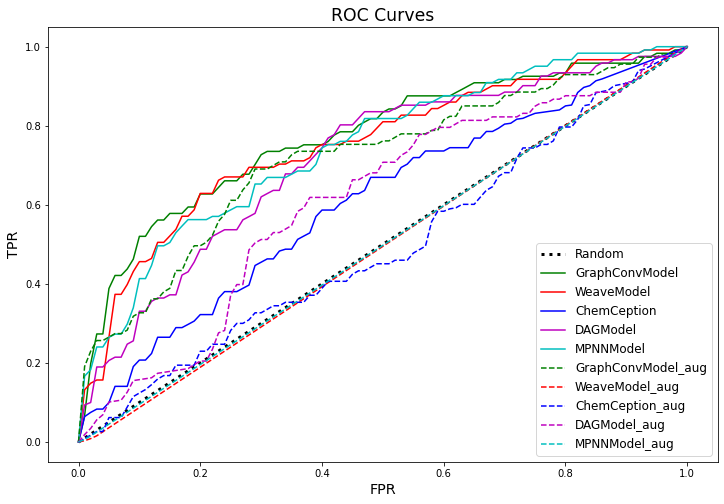

In [44]:
plt.figure(figsize=(12,8))

plt.plot([0,1], [0,1], label='Random', linestyle=':', color='k', linewidth=3)

plt.plot(np.array(roc_curve_data_plot['GraphConvModel']['fpr']), np.array(roc_curve_data_plot['GraphConvModel']['tpr']).mean(axis=0), label='GraphConvModel', color='g')
plt.plot(np.array(roc_curve_data_plot['WeaveModel']['fpr']), np.array(roc_curve_data_plot['WeaveModel']['tpr']).mean(axis=0), label='WeaveModel', color='r')
plt.plot(np.array(roc_curve_data_plot['ChemCeption']['fpr']), np.array(roc_curve_data_plot['ChemCeption']['tpr']).mean(axis=0), label='ChemCeption', color='b')
plt.plot(np.array(roc_curve_data_plot['DAGModel']['fpr']), np.array(roc_curve_data_plot['DAGModel']['tpr']).mean(axis=0), label='DAGModel', color='m')
plt.plot(np.array(roc_curve_data_plot['MPNNModel']['fpr']), np.array(roc_curve_data_plot['MPNNModel']['tpr']).mean(axis=0), label='MPNNModel', color='c')

plt.plot(np.array(roc_curve_data_augmented_plot['GraphConvModel']['fpr']), np.array(roc_curve_data_augmented_plot['GraphConvModel']['tpr']).mean(axis=0), label='GraphConvModel_aug', color='g', linestyle='--')
plt.plot(np.array(roc_curve_data_augmented_plot['WeaveModel']['fpr']), np.array(roc_curve_data_augmented_plot['WeaveModel']['tpr']).mean(axis=0), label='WeaveModel_aug', color='r', linestyle='--')
plt.plot(np.array(roc_curve_data_augmented_plot['ChemCeption']['fpr']), np.array(roc_curve_data_augmented_plot['ChemCeption']['tpr']).mean(axis=0), label='ChemCeption_aug', color='b', linestyle='--')
plt.plot(np.array(roc_curve_data_augmented_plot['DAGModel']['fpr']), np.array(roc_curve_data_augmented_plot['DAGModel']['tpr']).mean(axis=0), label='DAGModel_aug', color='m', linestyle='--')
plt.plot(np.array(roc_curve_data_augmented_plot['MPNNModel']['fpr']), np.array(roc_curve_data_augmented_plot['MPNNModel']['tpr']).mean(axis=0), label='MPNNModel_aug', color='c', linestyle='--')

plt.title('ROC Curves', fontsize='xx-large')
plt.ylabel('TPR', fontsize='x-large')
plt.xlabel('FPR', fontsize='x-large')
plt.legend(fontsize='large')

plt.show()
